In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [0]:
!unzip dataset.zip

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [0]:
data_transforms = {
    'Train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'Dataset/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['Train', 'Val', 'Test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=40, shuffle=True, num_workers=4) for x in ['Train', 'Val','Test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Train', 'Val','Test']}
class_names = image_datasets['Train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [5]:
print(class_names)
print(dataset_sizes)
print(image_datasets['Val'])

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
{'Train': 1644, 'Val': 210, 'Test': 208}
Dataset ImageFolder
    Number of datapoints: 210
    Root location: Dataset/Val


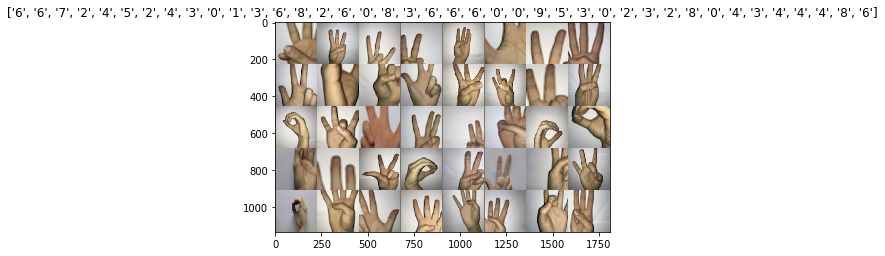

In [6]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['Train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Train', 'Val']:
            if phase == 'Train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'Val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['Test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: ' + str(class_names[preds[j]]) + ' original :' + str(labels[j].item()))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [0]:
def test_model_on_testdata(model):
  running_loss = 0 
  running_corrects = 0
  for i, (inputs, labels) in enumerate(dataloaders['Test']):
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
    
  #print(running_loss)
  print(str(running_corrects.item()) + ' / ' + str(dataset_sizes['Test']))
  print(str(running_corrects.item()/dataset_sizes['Test']) + " %")
  

In [10]:
model_ft = models.vgg19(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = False
#num_ftrs = model_ft.fc.in_features

mod = list(model_ft.classifier.children())
mod.pop()
mod.append(nn.Linear(4096,10))

model_ft.classifier = nn.Sequential(*mod)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:23<00:00, 24496486.35it/s]


In [11]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
Train Loss: 2.0713 Acc: 0.2457
Val Loss: 1.5782 Acc: 0.5667

Epoch 1/24
----------
Train Loss: 1.6820 Acc: 0.4088
Val Loss: 1.3438 Acc: 0.6333

Epoch 2/24
----------
Train Loss: 1.5391 Acc: 0.4550
Val Loss: 1.2074 Acc: 0.6429

Epoch 3/24
----------
Train Loss: 1.4578 Acc: 0.4866
Val Loss: 1.1363 Acc: 0.6286

Epoch 4/24
----------
Train Loss: 1.4460 Acc: 0.4818
Val Loss: 1.0354 Acc: 0.7286

Epoch 5/24
----------
Train Loss: 1.3876 Acc: 0.5128
Val Loss: 1.0412 Acc: 0.6810

Epoch 6/24
----------
Train Loss: 1.3872 Acc: 0.5231
Val Loss: 0.9835 Acc: 0.7190

Epoch 7/24
----------
Train Loss: 1.3498 Acc: 0.5304
Val Loss: 0.9765 Acc: 0.7381

Epoch 8/24
----------
Train Loss: 1.3381 Acc: 0.5304
Val Loss: 0.9708 Acc: 0.7381

Epoch 9/24
----------
Train Loss: 1.3425 Acc: 0.5335
Val Loss: 0.9665 Acc: 0.7476

Epoch 10/24
----------
Train Loss: 1.3266 Acc: 0.5401
Val Loss: 0.9639 Acc: 0.7476

Epoch 11/24
----------
Train Loss: 1.3541 Acc: 0.5195
Val Loss: 0.9587 Acc: 0.7714

Ep

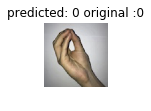

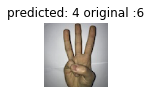

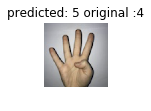

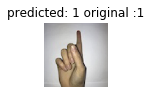

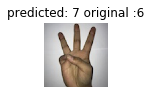

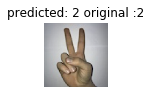

In [12]:
visualize_model(model_ft)

In [13]:
test_model_on_testdata(model_ft)

169 / 208
0.8125 %
